IMPORT VARIABLES

In [343]:
import torch
import math
import cv2
from tqdm import tqdm
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from scipy import signal,misc
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2,fftshift,fft,ifft2,ifftshift
from empatches import EMPatches
import imgviz  # just for plotting
import numpy as np
from skimage import color, data, restoration
from functions import *

DECLARE GLOBAL VARIABLES

In [344]:
N = 128# Kernel Size
radius = N//5 #np.sqrt(N//np.pi) #Radius of the aperture
center = [N//2,N//2]
lam = 0.55 * 10**-6
wave_number = 2*np.pi/lam
W_d = 0 
W_sa = 0
W_coma= 5 * lam
W_astig = 0
W_field = 0
W_distort  = 0 
#Shift of point in test image
side =2
x_shift = 10
y_shift  = 0
#For patching
patch_size = 64
step_size = 32
overlapPercent = 1- (step_size/patch_size)

In [345]:
amp = amplitude_aperture(N,radius,center)
phase_mask = phase_aperture(N,center,radius,wave_number,1,0)
pupil = amp*(phase_mask)
A,B,C,D = expand_complex_image(pupil)


SHOW PHASE FUNCTION


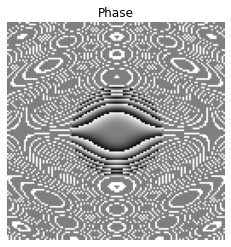

0.9999968417241228 -0.9999968417241228


In [346]:
plt.figure(1)
plt.title(r"Phase")
plt.imshow(D,cmap='gray');
plt.axis("off")
plt.show()
print(np.max(B),np.min(B))


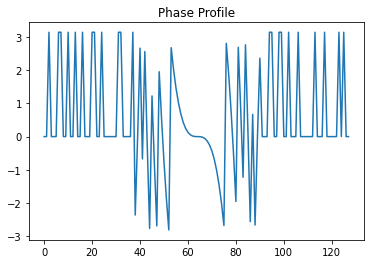

In [347]:
#Line plot
arr = D[:,N//2]
plt.figure(2)
plt.plot(arr)
plt.title(r"Phase Profile")
plt.axis("on")
plt.show()

#print(arr)

217978.28277946112


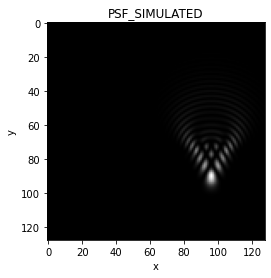

In [348]:
q = np.roll(get_mag(fft_image(pupil))**2,(32,32),axis=(0,1))
print(np.max(q))
plt.figure(4)
plt.title(r"PSF_SIMULATED")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('on')
plt.imshow(q, cmap='gray')

466.88144402991765


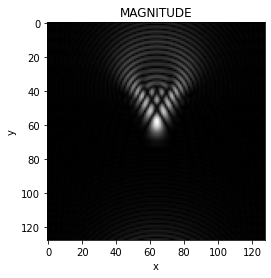

In [349]:
l = get_mag(fft_image(pupil))
print(np.max(l))
plt.figure(5)
plt.title(r"MAGNITUDE")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('on')
plt.imshow(l, cmap='gray')

UPLOAD TEST IMAGE 


(512, 512)


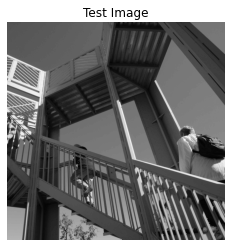

In [350]:
# get image either RGB or Grayscale
#img = cv2.imread('test.jpeg')
img = misc.ascent()
img_p = np.pad(img,step_size)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img_s = star_field(img.shape,64)
#img_s = np.pad(img_s,step_size)
img_R = np.sqrt((img.shape[0]//2)**2 +(img.shape[1]//2)**2)
#img = np.zeros((128,128),dtype=float)
#img[img.shape[0]//2-side//2-x_shift:img.shape[0]//2+side//2-x_shift,
     #img.shape[1]//2-side//2-y_shift:img.shape[1]//2+side//2-y_shift] = 1
# plot the test image
plt.figure(4)
plt.title(r"Test Image")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('off')
plt.imshow(img,cmap='gray')
print(img.shape)


INTERPOLATION FUNCTION

In [351]:

out = tri(4)
#window = np.zeros((16,16))
#window[0:3,0:3] = tri(3)

print(out)


[[0.   0.   0.   0.  ]
 [0.   0.25 0.5  0.25]
 [0.   0.5  1.   0.5 ]
 [0.   0.25 0.5  0.25]]


MERGE PATCHES

In [352]:
#------------------------------#
# ---------PATCHING -----------#
#------------------------------#
emp = EMPatches()
norm_factor = generate_norm_factor(img_p.shape,patch_size,step_size)
norm_patches,indcs = emp.extract_patches(norm_factor, patchsize=patch_size, overlap=overlapPercent)
img_patches, indices = emp.extract_patches(img_p, patchsize=patch_size, overlap=overlapPercent)
imgs_patches,indices1 = emp.extract_patches(img_p, patchsize=patch_size, overlap=overlapPercent)


CALCULATE PSFS

In [353]:


psf_arr = []
for ind in tqdm(indices):
    X = (ind[0] + ind[1])/2
    Y = (ind[2]+ind[3])/2
    p0 = (X-img.shape[0]/2)/img_R
    q0 = (Y-img.shape[1]/2)/img_R
    G = amp*(phase_aperture(N,center,radius,wave_number,p0,q0))
    p_norm = get_mag(fft_image(G))**2
    p_norm = p_norm/np.sum(p_norm)
    psf_arr.append(p_norm)
    #print(p0,q0)



100%|██████████| 289/289 [00:59<00:00,  4.88it/s]


215.62469582607292


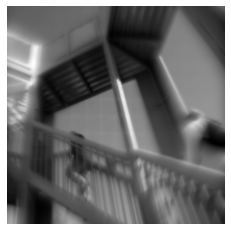

In [381]:


window = np.zeros(img_p.shape,float)
sum = np.zeros(img_p.shape,dtype=float)
for id,patch in enumerate(img_patches):
    
    ind = indices[id]
    window[ind[0]:ind[1],ind[2]:ind[3]]= tri(patch_size)
    temp = cv2.filter2D((window*img_p),-1,np.flip(psf_arr[id],-1),cv2.BORDER_CONSTANT)
    #temp1 =cv2.filter2D(window*norm_factor,-1,psf_arr[id],cv2.BORDER_CONSTANT)
    #temp = window*norm_factor
    sum = sum + temp
    #sum1 = sum1+temp1
    window[ind[0]:ind[1],ind[2]:ind[3]]= 0
sum= sum[patch_size:sum.shape[0]-patch_size,patch_size:sum.shape[1]-patch_size]
sum = sum
print(np.max(sum))
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.axis('off')
plt.imshow(sum,cmap='gray')
#print(sum)

In [355]:
# result =[]

# for id,patch in enumerate(img_patches):
#     ind = indices[id]
#     temp = cv2.filter2D(patch,-1,np.flip(psf_arr[id],-1),cv2.BORDER_CONSTANT)
#     temp = temp
#     result.append(temp)
    
# result =  np.array(result)
# merged_img = emp.merge_patches(result, indices)

# plt.figure()
# plt.xlabel('x')
# plt.ylabel('y')
# plt.axis('off')
# plt.imshow(merged_img,cmap='gray')


PSF MAP FOR THE IAMGE



In [356]:
# result =[]

# for id,patch in enumerate(img_patches):
#     ind = indices[id]
#     temp = cv2.filter2D(patch,-1,psf_arr[id],cv2.BORDER_CONSTANT)
#     #temp = norm_patches[id]
#     result.append(temp)
    
# result =  np.array(result)
# merged_img = emp.merge_patches(result, indices)

# plt.figure()
# plt.axis('off')
# plt.imshow(merged_img,'gray')

DECONVOLUTION

/Users/arnabghosh/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:682: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x, subok=True, copy=copy)


TypeError: Image data of dtype object cannot be converted to float

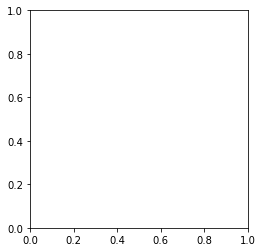

In [361]:
deconv_img = restoration.unsupervised_wiener(img, psf_arr[0])
plt.figure()
plt.imshow(deconv_img,'gray')

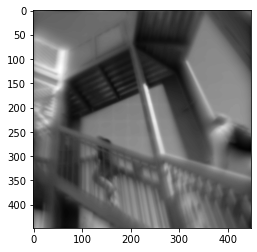

In [387]:
#Weiner Deconvolution Filter#
def wiener_filter(img, kernel, K = 10):
    dummy = np.copy(img)
    F = dummy.shape[0] - kernel.shape[0]
    G = dummy.shape[1] - kernel.shape[1]
    kernel = np.pad(kernel, [(F//2,F//2), (G//2,G//2)], 'constant')
    # Fourier Transform
    dummy = fft2(dummy)
    kernel = fft2(kernel)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = ifftshift(np.abs(ifft2(ifftshift(dummy))))
    return np.uint8(dummy)


deconv_img = wiener_filter(sum, psf_arr[len(psf_arr)//2],1)
plt.figure()
plt.imshow(deconv_img,'gray')

In [ ]:

out_patches, out_indices = emp.extract_patches(sum, patchsize=patch_size, overlap=overlapPercent)
deconv_out = np.zeros(sum.shape,dtype=float)
window = np.zeros(sum.shape,float)
for id,patch in enumerate(out_patches):
    ind = indices_out[id]
    window[ind[0]:ind[1],ind[2]:ind[3]]= tri(patch_size)
    psf = psf_arr[id]
    deconv_img = wiener_filter((window*img),psf,1)
    deconv_out = deconv_img + deconv_out
    window[ind[0]:ind[1],ind[2]:ind[3]]= 0
deconv_out= deconv_out[patch_size:deconv_out.shape[0]-patch_size,patch_size:deconv_out.shape[1]-patch_size]
plt.figure()
plt.axis('off')
plt.imshow(deconv_out,'gray')

ValueError: operands could not be broadcast together with shapes (448,448) (512,512) 